In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### The original code is provided below, followed by my solution

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [6]:
for p in parameters:
  p.requires_grad = True

In [7]:
lri = []
lossi = []
stepi = []

In [8]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

In [9]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1512, grad_fn=<NllLossBackward0>)

In [10]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1888, grad_fn=<NllLossBackward0>)

### E01: Tune the hyperparameters of the training to beat my best validation loss of 2.2
I've decided to increase the context window and the number of iterations while adjusting the learning rate

In [62]:
# build the dataset
block_size = 4 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182424, 4]) torch.Size([182424])
torch.Size([22836, 4]) torch.Size([22836])
torch.Size([22886, 4]) torch.Size([22886])


In [63]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_size = 10
hidden_layer_dim = 200
stoi_len = len(stoi)
ema_alpha = 0.05
C = torch.randn((stoi_len, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_dim), generator=g)
b1 = torch.randn(hidden_layer_dim, generator=g)
W2 = torch.randn((hidden_layer_dim, stoi_len), generator=g)
b2 = torch.randn(stoi_len, generator=g)
parameters = [C, W1, b1, W2, b2]

In [64]:
for p in parameters:
  p.requires_grad = True
lossi = []
loss_dev = []
stepi = []
step_dev = []
cur_i = 0

In [65]:
for _ in range(1_000_000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  if cur_i < 200_000:
      lr = 0.1
  elif cur_i < 400_000:
      lr = 0.01
  else:
      lr = 0.001 * 400_000 / cur_i
  for p in parameters:
    p.data += -lr * p.grad

  if cur_i % 20000 == 0 and cur_i >= 1000:
    #emb = C[Xtr] # (32, 3, 2)
    with torch.no_grad():
        dev_emb = C[Xdev]
        dev_h = torch.tanh(dev_emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
        dev_logits = dev_h @ W2 + b2 # (32, 27)
        dev_loss = F.cross_entropy(dev_logits, Ydev)
        loss_dev.append(dev_loss)
        step_dev.append(cur_i)
        print(f'iteration - {cur_i}, dev loss - {dev_loss}')
    
      
  if cur_i % 2000 == 0 and cur_i >= 1000:
      if not len(lossi):
          lossi.append(loss.item())
      else:
          ema_loss = (1 - ema_alpha) * lossi[len(lossi) - 1] + ema_alpha * loss.item()
          lossi.append(ema_loss)
          print(f'iteration - {cur_i}, loss - {ema_loss}')
      stepi.append(cur_i)
  cur_i += 1

iteration - 4000, loss - 3.212202787399292
iteration - 6000, loss - 3.183758807182312
iteration - 8000, loss - 3.17007453083992
iteration - 10000, loss - 3.1256026913523676
iteration - 12000, loss - 3.0966542547255753
iteration - 14000, loss - 3.0479997183923424
iteration - 16000, loss - 3.020392475201912
iteration - 18000, loss - 2.9922553964361702
iteration - 20000, dev loss - 2.5470049381256104
iteration - 20000, loss - 2.9844087336967284
iteration - 22000, loss - 2.9553563511157432
iteration - 24000, loss - 2.9313694874440803
iteration - 26000, loss - 2.909467513163429
iteration - 28000, loss - 2.872308294037545
iteration - 30000, loss - 2.858266069547917
iteration - 32000, loss - 2.859547714743769
iteration - 34000, loss - 2.8456695788463633
iteration - 36000, loss - 2.8195400792054977
iteration - 38000, loss - 2.8217959691890093
iteration - 40000, dev loss - 2.433692693710327
iteration - 40000, loss - 2.8108567988194637
iteration - 42000, loss - 2.7822983667802546
iteration - 440

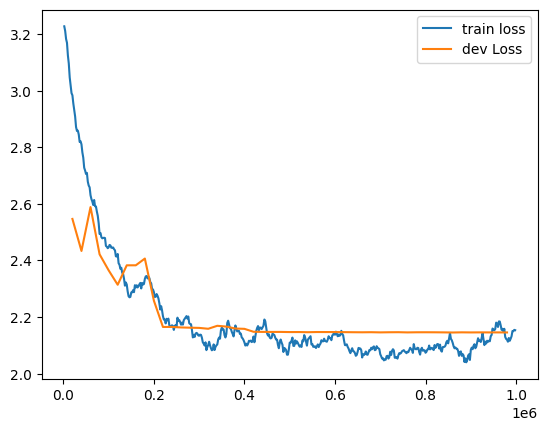

In [77]:
share = int(len(stepi))
plt.plot(stepi, lossi, label='train loss')
plt.plot(step_dev, loss_dev, label='dev Loss')
plt.legend()

### My score

In [78]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0850, grad_fn=<NllLossBackward0>)

In [79]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1453, grad_fn=<NllLossBackward0>)

### E02: I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

In [17]:
# Since the distribution is uniform, all probabilities are equal and therefore the loss has the following form
# where n is the number of possible answers
n = 27
-torch.log(torch.tensor(1/n))

tensor(3.2958)

In [35]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_size = 10
hidden_layer_dim = 200
stoi_len = len(stoi)
ema_alpha = 0.05
C = torch.randn((stoi_len, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_dim), generator=g)
b1 = torch.zeros(hidden_layer_dim)
W2 = torch.randn((hidden_layer_dim, stoi_len), generator=g)
b2 = torch.zeros(stoi_len)
parameters = [C, W1, b1, W2, b2]

In [36]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(24.7028)

In [ ]:
# Our initial loss reaches about 20, as there is a preponderance of some classes due to incorrect initialization

In [39]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_size = 10
hidden_layer_dim = 200
stoi_len = len(stoi)
ema_alpha = 0.05
std = 0.1
C = torch.randn((stoi_len, embedding_size), generator=g) * std
W1 = torch.randn((block_size * embedding_size, hidden_layer_dim), generator=g) * std
b1 = torch.zeros(hidden_layer_dim)
W2 = torch.randn((hidden_layer_dim, stoi_len), generator=g) * std
b2 = torch.zeros(stoi_len)
parameters = [C, W1, b1, W2, b2]

In [40]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.2994)

## E03: Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

In [1]:
# I just added the regularization term to the loss from this paper. In this paper, the authors also implemented skip connections,
# but they didn't yield better results

In [83]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_size = 10
hidden_layer_dim = 200
stoi_len = len(stoi)
ema_alpha = 0.05
C = torch.randn((stoi_len, embedding_size), generator=g)
W1 = torch.randn((block_size * embedding_size, hidden_layer_dim), generator=g)
b1 = torch.randn(hidden_layer_dim, generator=g)
W2 = torch.randn((hidden_layer_dim, stoi_len), generator=g)
b2 = torch.randn(stoi_len, generator=g)
parameters = [C, W1, b1, W2, b2]

In [84]:
for p in parameters:
  p.requires_grad = True
lossi = []
loss_dev = []
stepi = []
step_dev = []
cur_i = 0

In [ ]:
for _ in range(1_000_000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix]) + (W1**2).mean() + (W2**2).mean()
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  if cur_i < 200_000:
      lr = 0.1
  elif cur_i < 400_000:
      lr = 0.01
  else:
      lr = 0.001 * 400_000 / cur_i
  for p in parameters:
    p.data += -lr * p.grad

  if cur_i % 20000 == 0 and cur_i >= 1000:
    #emb = C[Xtr] # (32, 3, 2)
    with torch.no_grad():
        dev_emb = C[Xdev]
        dev_h = torch.tanh(dev_emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
        dev_logits = dev_h @ W2 + b2 # (32, 27)
        dev_loss = F.cross_entropy(dev_logits, Ydev)
        loss_dev.append(dev_loss)
        step_dev.append(cur_i)
        print(f'iteration - {cur_i}, dev loss - {dev_loss}')
    
      
  if cur_i % 2000 == 0 and cur_i >= 1000:
      if not len(lossi):
          lossi.append(loss.item())
      else:
          ema_loss = (1 - ema_alpha) * lossi[len(lossi) - 1] + ema_alpha * loss.item()
          lossi.append(ema_loss)
          print(f'iteration - {cur_i}, loss - {ema_loss}')
      stepi.append(cur_i)
  cur_i += 1

iteration - 4000, loss - 3.9551005244255064
iteration - 6000, loss - 3.9479083424806594
iteration - 8000, loss - 3.9225185072124
iteration - 10000, loss - 3.8940403131559487
iteration - 12000, loss - 3.884588687074109
iteration - 14000, loss - 3.842794698505926
iteration - 16000, loss - 3.814024750319979
iteration - 18000, loss - 3.778423786889978
iteration - 20000, dev loss - 2.3544983863830566
iteration - 20000, loss - 3.760323072170113
iteration - 22000, loss - 3.7106290215851363
iteration - 24000, loss - 3.6686013794810988
iteration - 26000, loss - 3.635537485681757
iteration - 28000, loss - 3.5952640765732977
iteration - 30000, loss - 3.562077611102177
iteration - 32000, loss - 3.498810578329203
iteration - 34000, loss - 3.4346571072893295
iteration - 36000, loss - 3.3898509363044402
iteration - 38000, loss - 3.3485420285387484
iteration - 40000, dev loss - 2.3455774784088135
iteration - 40000, loss - 3.3121262701141303
iteration - 42000, loss - 3.2566795802313178
iteration - 4400

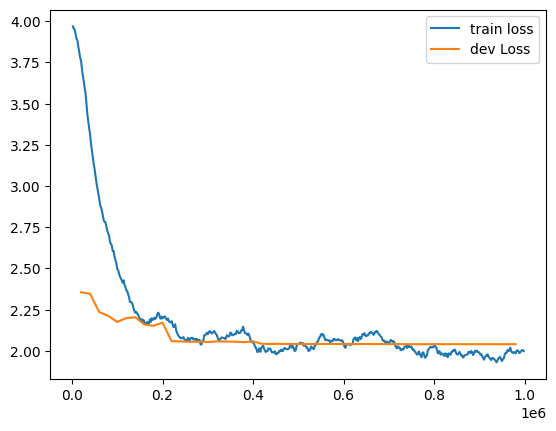

In [87]:
share = int(len(stepi))
plt.plot(stepi, lossi, label='train loss')
plt.plot(step_dev, loss_dev, label='dev Loss')
plt.legend()

In [88]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.9488, grad_fn=<NllLossBackward0>)

In [89]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0394, grad_fn=<NllLossBackward0>)